# 1-Preps

## 1-1-Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mat73

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics, models

from sklearn.metrics import ConfusionMatrixDisplay as CMD
# from sklearn.utils import class_weight

import os
import datetime
import pickle
from tqdm import tqdm

## 1-2-Config

In [7]:
INPUT_SHAPE = (512,512)
TRAIN_SIZE = 0.9
BATCH_SIZE = 8
SEED = 41
TRAINING_PHASE = False
USE_MAT = True

## 1-3-Helper Func

In [8]:
def open_npy(path):
    def _open_npy(path):
        arr = np.load(path).astype('float')
        shape = np.asarray(arr.shape).astype('int')
        return arr, shape
    
    tensor, shape = tf.numpy_function(_open_npy, [path], [tf.double, tf.int32])
    tensor = tf.reshape(tensor, shape)
    
    return tensor

def open_mat(path):
    def _open_mat(path):
        data_dict = mat73.loadmat(path)['cjdata']
        images = np.expand_dims(data_dict['image'], axis=-1).astype('float')
        masks = np.expand_dims(data_dict['tumorMask'], axis=-1).astype('float')
        labels = data_dict['label'].astype('int')
        shape = np.asarray(images.shape).astype('int')
        return images, masks, labels, shape
    
    image, mask, label, shape = tf.numpy_function(_open_mat, [path], [tf.double, tf.double, tf.int32, tf.int32])
    image = tf.reshape(image, shape)
    mask = tf.reshape(mask, shape)
    
    return image, mask, label
        

# has problems with resizing mask ## fix it ##    
def im_resizer_and_rescaler(pid, im, mask, label, rescale = 1/12728, resize=INPUT_SHAPE):
    im = tf.multiply(im, rescale)
    im = tf.image.resize(im, size=resize)
    return pid, scaledAndResized, mask, label

def ds_sanity_check(ds, n):
    for j, element in enumerate(ds.take(n)):
        print('='*10 + 'element: ' + str(j) + '='*10)
        for i, col in enumerate(element):
            print(f'col_{i}.shape:{col.numpy().shape},\nvalues:\n{col.numpy()}\nmax:{col.numpy().max()}')
            print('_'*25)

def plot_lc(History):
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    fig.suptitle('Learning Curves', fontsize=16)
    axes[0].set_title('For Loss Function')
    axes[1].set_title('For Accuracy')


    for metric in History.keys():
        i=0 if not metric.endswith('accuracy') else 1
        color='green' if metric.startswith('val') else 'orange'
        axes[i].plot(range(1,1+len(History[metric])), History[metric], color=color, label = metric)
        axes[i].legend(loc="upper left")
        axes[i].set_xlabel('Number of Epochs')
    
    plt.show()

## 1-4-TF Data Pipeline

In [9]:
if USE_MAT:
    target_shape = (512,512,1)

    ds = tf.data.Dataset.list_files('DATA/data/*.mat', shuffle=False)
    ds = ds.shuffle(3049, seed=SEED, reshuffle_each_iteration=False)
    ds = ds.map(open_mat)
    #ds = ds.filter(lambda im,ma,la:tf.shape(im)==target_shape)
    ds = ds.map(lambda im,ma,la:(tf.ensure_shape(im, target_shape), tf.ensure_shape(ma, target_shape), tf.ensure_shape(la, ())))
    ds = ds.map(lambda im,ma,la:(tf.multiply(im, 1/tf.reduce_max(im)), ma, tf.one_hot(tf.cast(tf.add(la, -1), tf.int32), depth=3)))
else:
    x_ds = tf.data.Dataset.list_files('DATA/as_numpy/image/*.npy', shuffle=False).shuffle(3049, seed=SEED, reshuffle_each_iteration=False).map(open_npy).map(lambda arr:tf.ensure_shape(arr, (512,512,1))).map(lambda x:tf.multiply(x, 1/tf.reduce_max(x)))
    mask_ds = tf.data.Dataset.list_files('DATA/as_numpy/mask/*.npy', shuffle=False).shuffle(3049, seed=SEED, reshuffle_each_iteration=False).map(open_npy).map(lambda arr:tf.ensure_shape(arr, (512,512,1)))
    y_ds = tf.data.Dataset.list_files('DATA/as_numpy/label/*.npy', shuffle=False).shuffle(3049, seed=SEED, reshuffle_each_iteration=False).map(open_npy).map(lambda arr:tf.ensure_shape(arr, ())).map(lambda x:tf.cast(tf.add(x, -1), tf.int32)).map(lambda y:tf.one_hot(y, depth=3))
    ds = tf.data.Dataset.zip((x_ds, mask_ds, y_ds))#.map(open_npy)

print(len(ds))
ds.element_spec


3049


(TensorSpec(shape=(512, 512, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(512, 512, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(3,), dtype=tf.float32, name=None))

In [10]:
label_dict = {0:"meningioma", 1:"glioma", 2:"pituitary"}

### 1-4-1-Train/Val Split

In [11]:
train_ds = ds.take(int(TRAIN_SIZE*len(ds)))
val_ds = ds.skip(int(TRAIN_SIZE*len(ds)))

In [12]:
#12728

### 1-4-2-Visualization

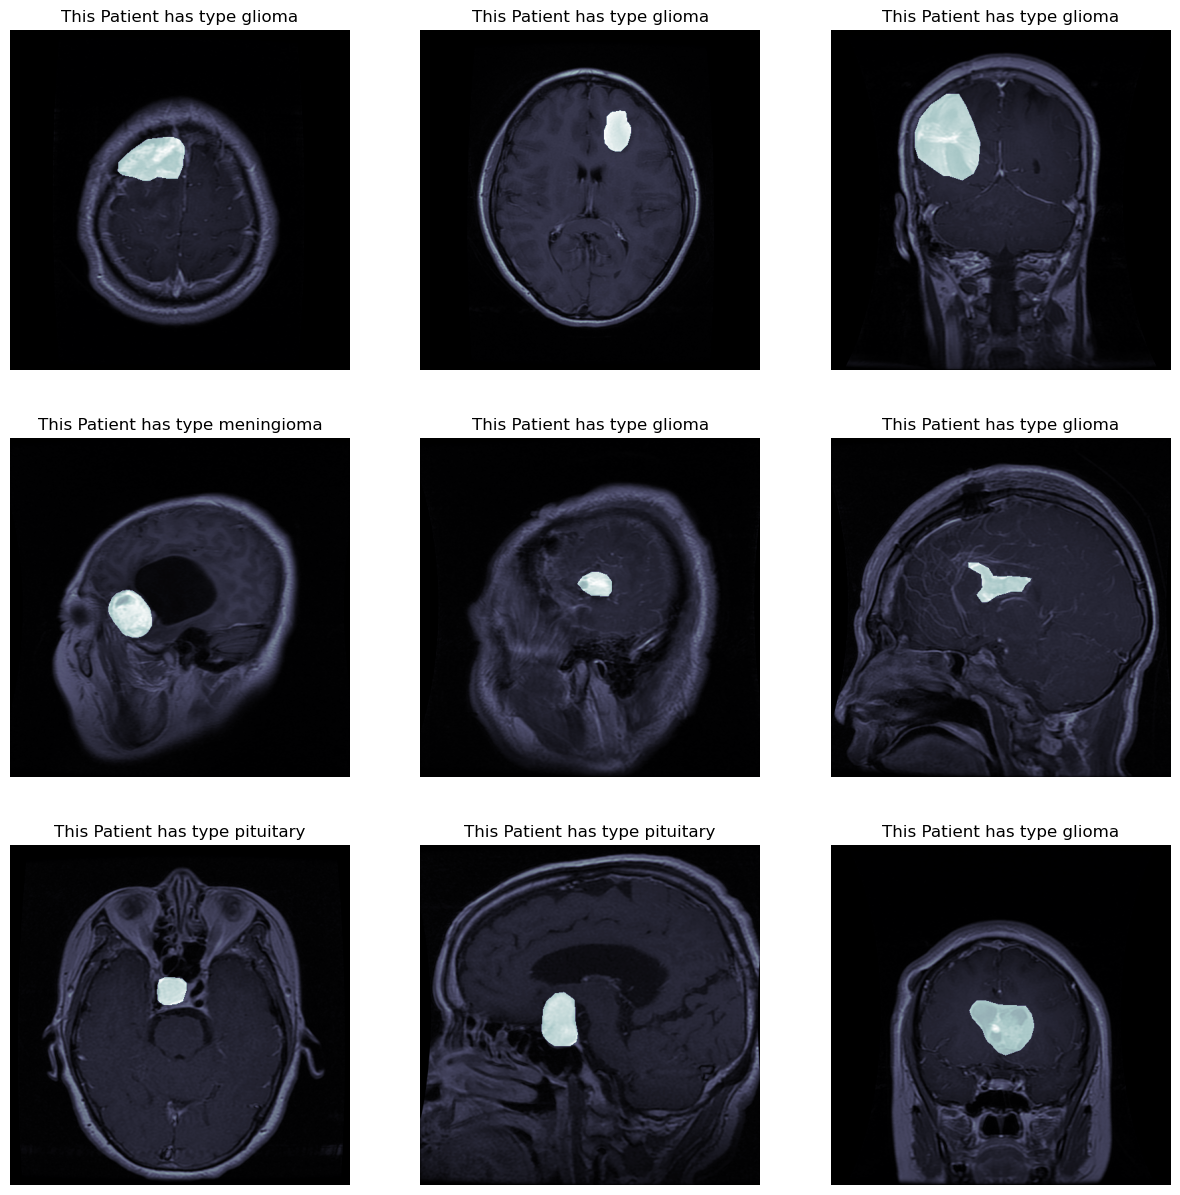

In [13]:
nrows, ncols = 3, 3

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))

it = iter(ds)

for i in range(nrows):
    for j in range(ncols):
        im, mask, label = next(it)
        label = label_dict[np.argmax((label.numpy()))]
        axes[i,j].imshow(tf.squeeze(im) +  tf.squeeze(mask), cmap='bone')
        axes[i,j].axis('off')
        axes[i,j].set_title('This Patient has type ' + str(label))
plt.show()

# 2-Classification

## 2-1-Images and Labels

In [14]:
train_ds_classification = train_ds.map(lambda im, mask, label:(im, label)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds_classification = val_ds.map(lambda im, mask, label:(im, label)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
# ds_sanity_check(val_ds_classification, 1)

## 2-2-CNN

In [16]:
def get_CNN(filters, kernel_sizes, activation='relu', aug_factor=0.2, lr=0.001):
    # Instantiating
    model = models.Sequential()
    
    model.add(layers.Input(shape=(INPUT_SHAPE[0], INPUT_SHAPE[1], 1)))
    # Preprocess
#     model.add(layers.Resizing(INPUT_SHAPE[0], INPUT_SHAPE[1]))
#     model.add(layers.Rescaling(scale=1/12728))
#     model.add(layers.Reshape((INPUT_SHAPE[0], INPUT_SHAPE[1], 1)))
    
    # Augmentation
#     model.add(layers.RandomFlip())
#     model.add(layers.RandomZoom([-aug_factor, aug_factor], [-aug_factor, aug_factor]))
#     model.add(layers.RandomRotation(aug_factor))

    # CNN Blocks
    for f, ks in zip(filters, kernel_sizes):
        model.add(layers.Conv2D(f, ks, activation=activation))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(f, ks, activation=activation))
        model.add(layers.MaxPooling2D())
        model.add(layers.Dropout(rate=0.1))
        model.add(layers.BatchNormalization())
    
    # FC Block
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(3))
    
    # Compilation
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss=losses.CategoricalCrossentropy(from_logits=True),
        metrics=[metrics.CategoricalAccuracy()]
    )
    
    return model


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                    patience = 5, restore_best_weights = False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('TEMP/cnn_checkpoint', 
                    monitor="val_categorical_accuracy", mode="max", 
                    save_best_only=True, verbose=0)
callbacks = [early_stop, checkpoint]

# Creating model
tf.keras.backend.clear_session()

if TRAINING_PHASE:
    CNN_model = get_CNN([32, 256, 512], [3,3,3], activation='relu', aug_factor=0.1, lr=0.001)
else:
    best_model_indx = np.argmax(list(map(lambda x:float(x.split('(')[-1].split(')')[0]), os.listdir('MODELS/CNN/'))))
    CNN_model = models.load_model('MODELS/CNN/' + os.listdir('MODELS/CNN/')[best_model_indx])

# Summary
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 126, 126, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     1

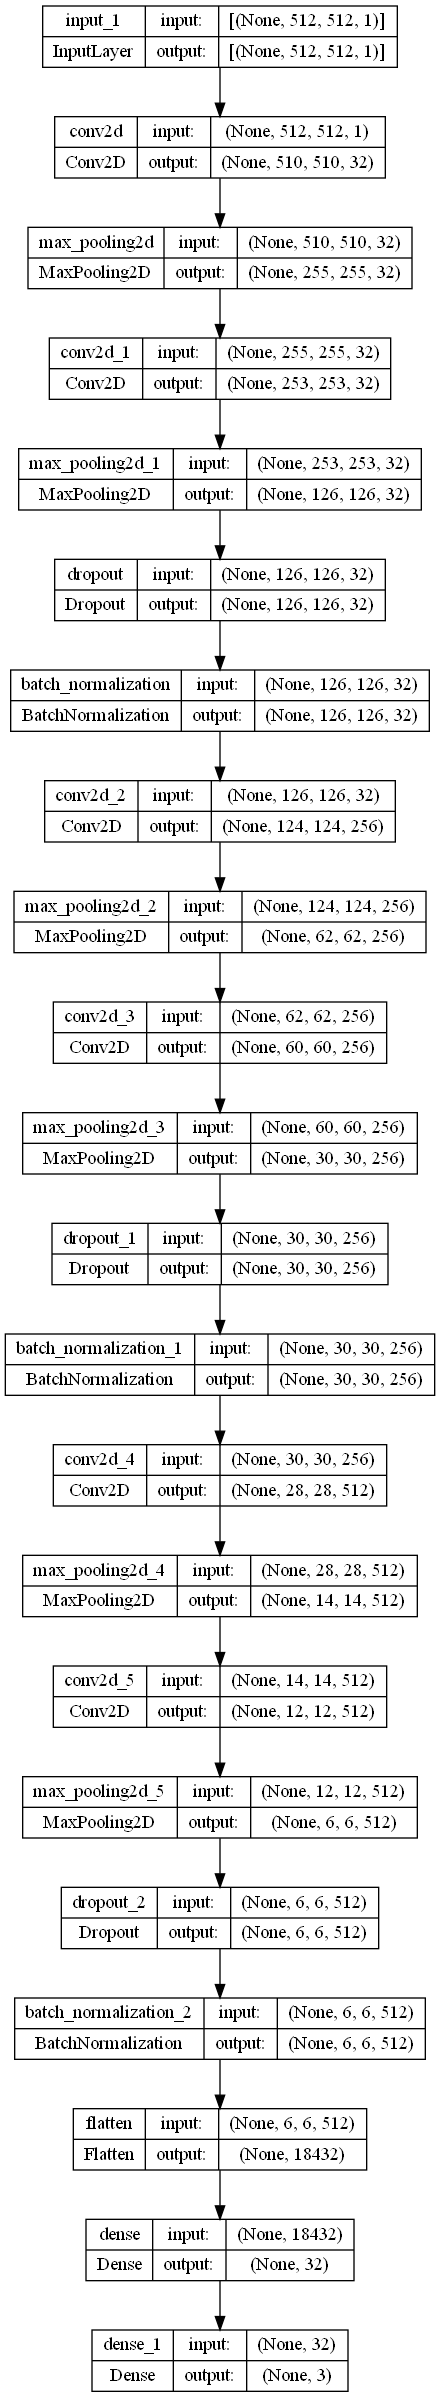

In [17]:
tf.keras.utils.plot_model(CNN_model, 'CNN_model.png', show_shapes=True)

In [18]:
if TRAINING_PHASE:
    history = CNN_model.fit(train_ds_classification, validation_data=val_ds_classification, epochs=40, callbacks=callbacks)
    CNN_model.load_weights('TEMP/cnn_checkpoint')
    History = history.history
else:
    with open('MODELS/CNN/' + os.listdir('MODELS/CNN/')[best_model_indx] + '/HISTORY.pkl', 'rb') as f:
        History = pickle.load(f)

### 2-2-1-Saving Model and History

In [19]:
if TRAINING_PHASE:
    time = str(datetime.datetime.now())[:16].replace(' ', '_').replace(':', '-')
    acc = max(History['val_categorical_accuracy'])
    CNN_model.save(f'MODELS/CNN/CNN_[{time}]_({acc:.2})')

    with open(f'MODELS/CNN/CNN_[{time}]_({acc:.2})/HISTORY.pkl','wb') as f:
        pickle.dump(History, f)

### 2-2-2-CNN Model Evaluation

In [20]:
CNN_model.evaluate(val_ds_classification)

39/39 [==============================] - 82s 179ms/step - loss: 0.2701 - categorical_accuracy: 0.9246


[0.2700965702533722, 0.9245901703834534]

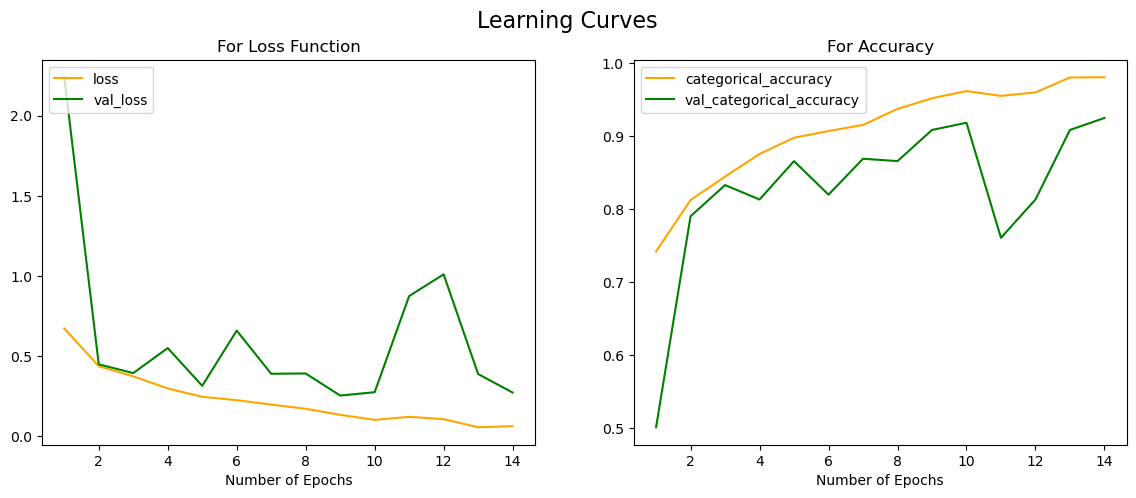

In [21]:
plot_lc(History)

In [22]:
p_train = np.argmax(CNN_model.predict(train_ds_classification), axis=1)
p_train = np.vectorize(label_dict.get)(p_train)
y_train = [np.argmax((i)) for _, i in train_ds_classification.unbatch()]
y_train = np.vectorize(label_dict.get)(y_train)

p_val = np.argmax(CNN_model.predict(val_ds_classification), axis=1)
p_val = np.vectorize(label_dict.get)(p_val)
y_val = [np.argmax((i)) for _, i in val_ds_classification.unbatch()]
y_val = np.vectorize(label_dict.get)(y_val)

fig, axes = plt.subplots(1,2)
CMD.from_predictions(y_val, p_val, ax=axes[0], colorbar=False, xticks_rotation='vertical')
axes[0].set_title("For Validation Set")
CMD.from_predictions(y_train, p_train, ax=axes[1], colorbar=False, xticks_rotation='vertical')
axes[1].set_title("For Train Set")
plt.tight_layout()
plt.show()

39/39 [==============================] - 35s 94ms/step


KeyboardInterrupt: 

## 2-3-Xception Transfer

In [ ]:
def get_Xception(lr=0.001, aug_factor=0.1):
    model = tf.keras.applications.xception.Xception(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=(512,512,3),
        pooling=None,
        classes=1000,
        classifier_activation='softmax'
    )
    
    for l in model.layers[:-16]:
        l.trainable=False
        
#     for l in model.layers:
#         print(l.name, l.trainable)
    
    inp = tf.keras.Input(shape=(INPUT_SHAPE[0], INPUT_SHAPE[1], 1))
#     x = layers.RandomFlip()(inp)
#     x = layers.RandomZoom([-aug_factor, aug_factor], [-aug_factor, aug_factor])(x)
#     x = layers.RandomRotation(aug_factor)(x)
    
    x = layers.Conv2D(3, (1,1))(inp)
    x = model(x)
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(3)(x)
    
    model = models.Model(inp, x)
    
    # Compilation
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss=losses.CategoricalCrossentropy(from_logits=True),
        metrics=[metrics.CategoricalAccuracy()]
    )
    
    return model

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                    patience = 5, restore_best_weights = False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('TEMP/cnn_checkpoint', 
                    monitor="val_categorical_accuracy", mode="max", 
                    save_best_only=True, verbose=0)
callbacks = [early_stop, checkpoint]

if TRAINING_PHASE:
    Xception_model = get_Xception()
else:
    best_model_indx = np.argmax(list(map(lambda x:float(x.split('(')[-1].split(')')[0]), os.listdir('MODELS/Xception'))))
    Xception_model = models.load_model('MODELS/Xception/' + os.listdir('MODELS/Xception')[best_model_indx])
    
# Summary
Xception_model.summary(expand_nested=True)

In [ ]:
tf.keras.utils.plot_model(Xception_model, 'Xception_model.png', show_shapes=True, expand_nested=True)

In [ ]:
if TRAINING_PHASE:
    history = Xception_model.fit(train_ds_classification, validation_data=val_ds_classification, epochs=40, callbacks=callbacks)
    Xception_model.load_weights('TEMP/cnn_checkpoint')
    History = history.history
else:
    with open('MODELS/Xception/' + os.listdir('MODELS/Xception/')[best_model_indx] + '/HISTORY.pkl', 'rb') as f:
        History = pickle.load(f)

### 2-3-1-Saving Model and History

In [ ]:
if TRAINING_PHASE:
    time = str(datetime.datetime.now())[:16].replace(' ', '_').replace(':', '-')
    acc = max(History['val_categorical_accuracy'])
    Xception_model.save(f'MODELS/Xception/Xception_[{time}]_({acc:.2})')

    with open(f'MODELS/Xception/Xception_[{time}]_({acc:.2})/HISTORY.pkl','wb') as f:
        pickle.dump(History, f)

### 2-3-2-Model Evaluation

In [ ]:
Xception_model.evaluate(val_ds_classification)

In [ ]:
plot_lc(History)

In [ ]:
p_train = np.argmax(Xception_model.predict(train_ds_classification), axis=1)
p_train = np.vectorize(label_dict.get)(p_train)
y_train = [np.argmax((i)) for _, i in train_ds_classification.unbatch()]
y_train = np.vectorize(label_dict.get)(y_train)

p_val = np.argmax(Xception_model.predict(val_ds_classification), axis=1)
p_val = np.vectorize(label_dict.get)(p_val)
y_val = [np.argmax((i)) for _, i in val_ds_classification.unbatch()]
y_val = np.vectorize(label_dict.get)(y_val)

fig, axes = plt.subplots(1,2)
CMD.from_predictions(y_val, p_val, ax=axes[0], colorbar=False, xticks_rotation='vertical')
axes[0].set_title("For Validation Set")
CMD.from_predictions(y_train, p_train, ax=axes[1], colorbar=False, xticks_rotation='vertical')
axes[1].set_title("For Train Set")
plt.tight_layout()
plt.show()

# 3-Semantic Segmentation

## 3-1-Image and Mask and Sample Weights

In [24]:
train_ds_segmentation = train_ds.map(lambda im, mask, label:(im, mask)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds_segmentation = val_ds.map(lambda im, mask, label:(im, mask)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [25]:
def add_weights(x, y):
    class_weights = tf.multiply(tf.constant([.5, .5]), 2)
    sample_weights = tf.gather(class_weights, indices=tf.cast(y, tf.int32))

    return x, y, sample_weights

## 3-2-UNet

In [26]:
def down_block(inp, filters, size, activation='relu'):
    x = layers.Conv2D(filters, size, padding='same', activation=activation)(inp)
    x = layers.Conv2D(filters, size, padding='same', activation=activation)(x)
    mp = layers.MaxPool2D()(x)
    
    return mp, x

def up_block(skip, x, filters, size, activation='relu'):
    x = layers.Conv2DTranspose(filters, (2,2), strides=2)(x)
    x = layers.Concatenate()([skip, x])
    x = layers.Conv2D(filters, size, padding='same', activation=activation)(x)
    x = layers.Conv2D(filters, size, padding='same', activation=activation)(x)
    
    return x

def get_UNet(activation='relu', lr=0.001):
    inp = tf.keras.Input(shape=(INPUT_SHAPE[0], INPUT_SHAPE[1], 1))
    
    mp1, skip1 = down_block(inp, 32, (3,3))
    mp2, skip2 = down_block(mp1, 64, (3,3))

    
    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(mp2)
    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    

    x = up_block(skip2, x, 64, (3,3))
    x = up_block(skip1, x, 32, (3,3))
    
    out = layers.Conv2D(1, (1,1))(x)
    #out = layers.Reshape((512,512))(x)
    
    model = models.Model(inp, out)
    
    # Compilation
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss=losses.BinaryCrossentropy(from_logits=True),
        metrics=[metrics.BinaryAccuracy()],
        weighted_metrics=[metrics.BinaryAccuracy()]
    )
    
    return model

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                    patience = 5, restore_best_weights = False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('TEMP/cnn_checkpoint', 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=0)
callbacks = [early_stop, checkpoint]

# Creating model
tf.keras.backend.clear_session()

if TRAINING_PHASE:
    UNet_model = get_UNet(activation='relu', lr=0.001)
else:
    best_model_indx = np.argmax(list(map(lambda x:float(x.split('(')[-1].split(')')[0]), os.listdir('MODELS/UNet/'))))
    UNet_model = models.load_model('MODELS/UNet/' + os.listdir('MODELS/UNet/')[best_model_indx])

# Summary
UNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

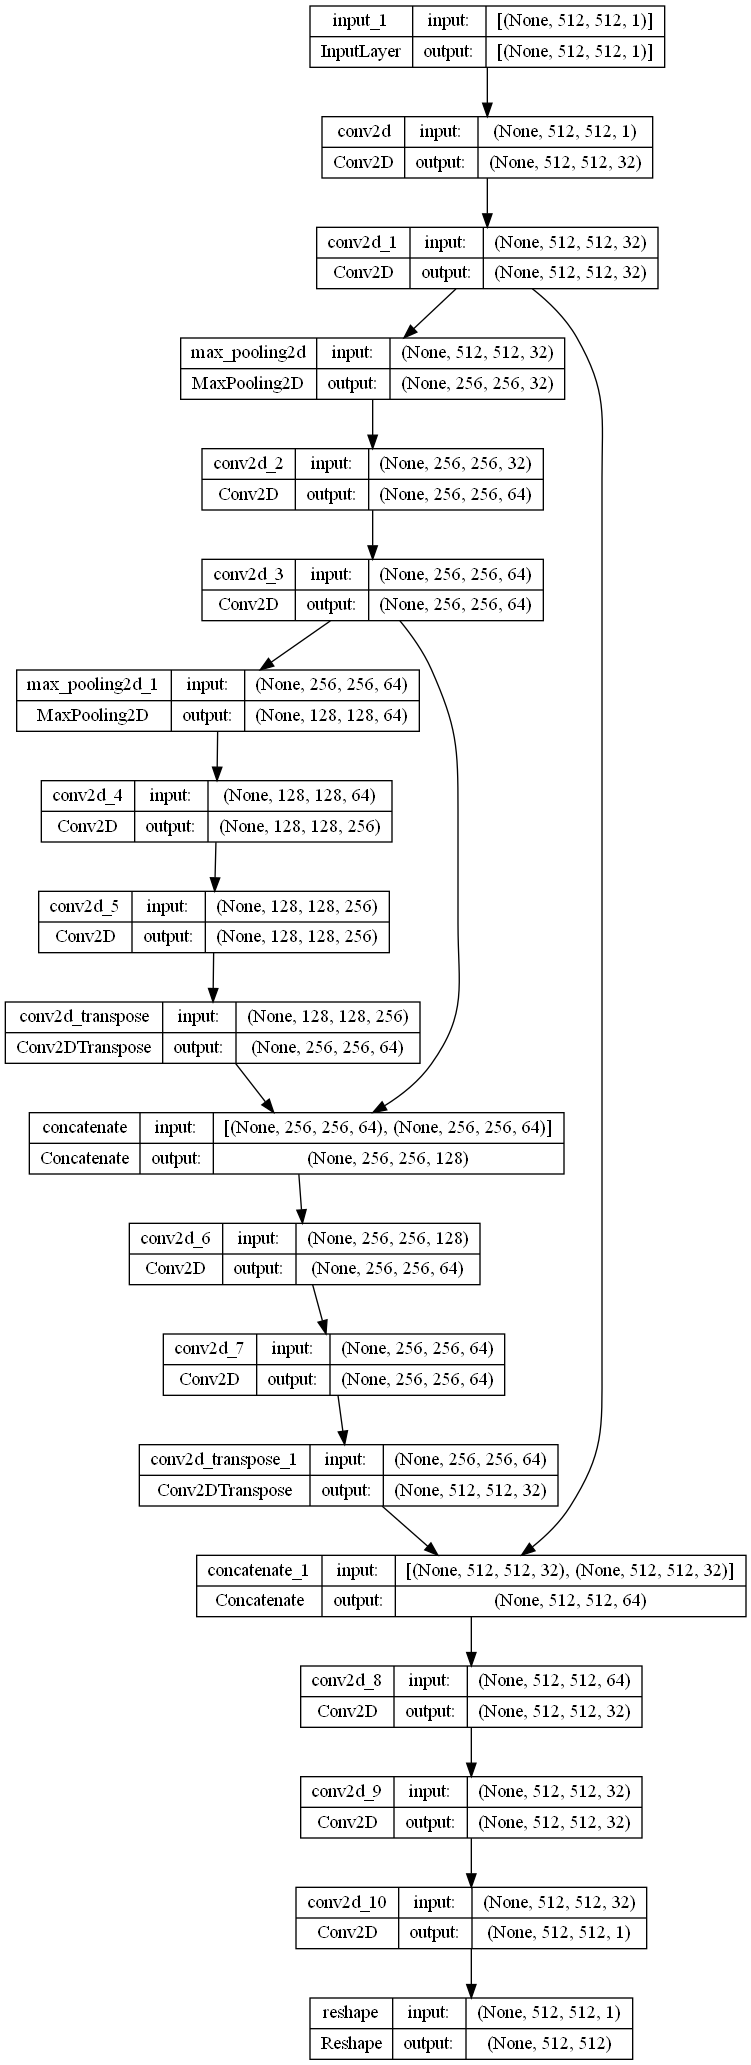

In [27]:
tf.keras.utils.plot_model(UNet_model, 'Unet_model.png', show_shapes=True)

In [28]:
if TRAINING_PHASE:
    history = UNet_model.fit(train_ds_segmentation.map(add_weights), validation_data=val_ds_segmentation.map(add_weights), epochs=60,
                             callbacks=callbacks)
    UNet_model.load_weights('TEMP/cnn_checkpoint')
    History = history.history
else:
    with open('MODELS/UNet/' + os.listdir('MODELS/UNet/')[best_model_indx] + '/HISTORY.pkl', 'rb') as f:
        History = pickle.load(f)

### 3-2-1-Saving Model and History

In [29]:
if TRAINING_PHASE:
    time = str(datetime.datetime.now())[:16].replace(' ', '_').replace(':', '-')
    loss = min(History['val_loss'])
    UNet_model.save(f'MODELS/UNet/UNet_[{time}]_({loss:.4})')

    with open(f'MODELS/UNet/UNet_[{time}]_({loss:.4})/HISTORY.pkl','wb') as f:
        pickle.dump(History, f)

### 3-2-2-Model Evaluation

In [30]:
UNet_model.evaluate(val_ds_segmentation)

39/39 [==============================] - 41s 121ms/step - loss: 0.0482 - binary_accuracy: 0.9854


[0.048247963190078735, 0.9853710532188416]

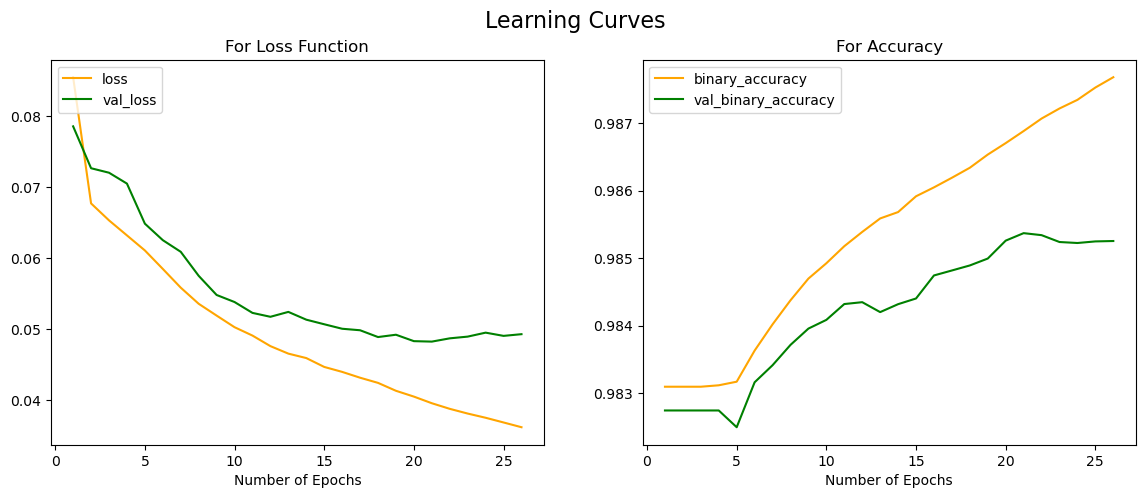

In [31]:
plot_lc(History)

In [32]:
it = iter(val_ds_segmentation)

1/1 [==============================] - 0s 61ms/step


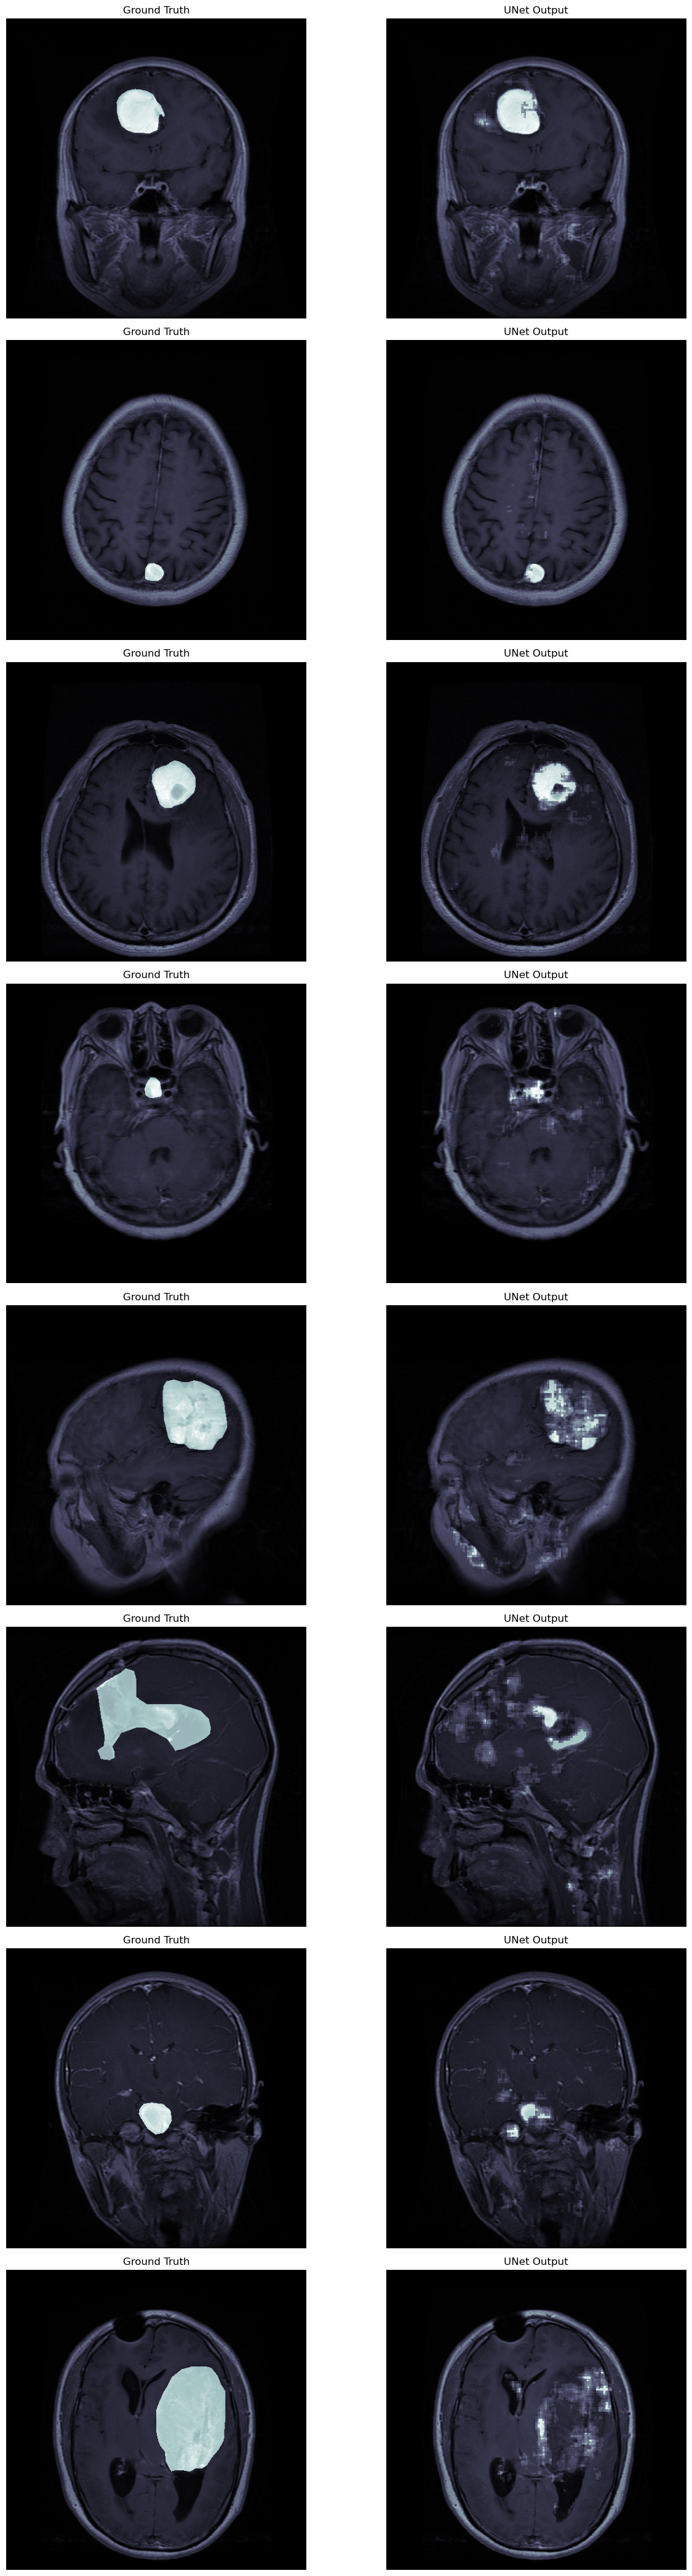

In [37]:
X, MASK = next(it)
P = tf.nn.sigmoid(UNet_model.predict(X)).numpy()

_max = np.max(P, axis=(1,2), keepdims=True)
_min = np.min(P, axis=(1,2), keepdims=True)

P = (P - _min)/(_max - _min)

P[P<0.1] = 0
P[P>0.6] = 1

fig, axes = plt.subplots(8,2, figsize=(14, 42))

for i in range(8):
    axes[i,0].imshow(X[i].numpy().squeeze() + MASK[i].numpy().squeeze(), cmap='bone')
    axes[i,1].imshow(X[i].numpy().squeeze() + P[i].squeeze(), cmap='bone')
    axes[i,0].axis('off')
    axes[i,0].set_title('Ground Truth')
    axes[i,1].axis('off')
    axes[i,1].set_title('UNet Output')
    
plt.tight_layout()
plt.show()

In [34]:
size = 0
sum_0 = 0
sum_1 = 0
for _, y in tqdm(train_ds_segmentation.unbatch()):
    size += y.numpy().size
    sum_0 += tf.reduce_sum(y)
    sum_1 += tf.reduce_sum(1-y)
    
mean_0 = sum_0/size
mean_1 = sum_1/size


mean_0, mean_1

2744it [00:39, 70.35it/s]


(<tf.Tensor: shape=(), dtype=float64, numpy=0.016904255391557432>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9830957446084426>)

In [ ]:
(mean_0.numpy(), mean_1.numpy())